In [1]:
import pandas as pd
df_clean = pd.read_csv('../data/airbnb_cleaned.csv')


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Create binary target column (1 = has TV, 0 = no TV)
df_class = df_clean.copy()
df_class['has_tv'] = df_class['amenities'].apply(lambda x: 1 if isinstance(x, str) and 'TV' in x else 0)

# Step 2: Select numeric features and drop missing rows
features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews', 'review_scores_rating']
df_class = df_class[features + ['has_tv']].dropna()

# Step 3: Define X and y
X = df_class[features]
y = df_class['has_tv']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Fit k-NN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Step 7: Evaluate model
y_pred = knn.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6324503311258278
Confusion Matrix:
 [[ 45 126]
 [ 96 337]]
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.26      0.29       171
           1       0.73      0.78      0.75       433

    accuracy                           0.63       604
   macro avg       0.52      0.52      0.52       604
weighted avg       0.61      0.63      0.62       604



In [3]:
from sklearn.utils import resample

# Separate classes
df_tv = df_class[df_class['has_tv'] == 1]
df_no_tv = df_class[df_class['has_tv'] == 0]

# Downsample class 1 (TV listings) to match class 0
df_tv_down = resample(df_tv, replace=False, n_samples=len(df_no_tv), random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_tv_down, df_no_tv]).sample(frac=1, random_state=42)


In [4]:
# Redefine features and target
X_bal = df_balanced[features]
y_bal = df_balanced['has_tv']

# Split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train k-NN
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# Evaluate
print("Balanced Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Balanced Accuracy: 0.5619834710743802
Confusion Matrix:
 [[ 96  87]
 [ 72 108]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.52      0.55       183
           1       0.55      0.60      0.58       180

    accuracy                           0.56       363
   macro avg       0.56      0.56      0.56       363
weighted avg       0.56      0.56      0.56       363



### Improving k-NN Classification Through Class Balancing

Our initial k-NN classification model predicted whether a listing included a TV as an amenity. While it achieved 63% accuracy, it was heavily biased toward predicting listings with TVs, due to a significant class imbalance. To address this, we applied **undersampling** to the majority class (listings with TVs) to create a balanced dataset for model training.

After retraining the k-NN classifier on the balanced data, the model achieved a more equitable performance across both classes, with a balanced accuracy of **56.2%**. Precision and recall were nearly identical for both classes, and f1-scores hovered around **0.56–0.58**, showing that the model was no longer biased toward the majority class. While overall accuracy dropped slightly, the model became much more **realistic and fair**, which is critical when both outcomes matter. This trade-off highlights the importance of addressing class imbalance in classification tasks.


In [5]:
from sklearn.utils import resample

# Separate classes
df_tv = df_class[df_class['has_tv'] == 1]
df_no_tv = df_class[df_class['has_tv'] == 0]

# Downsample class 1 (TV listings) to match class 0
df_tv_down = resample(df_tv, replace=False, n_samples=len(df_no_tv), random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_tv_down, df_no_tv]).sample(frac=1, random_state=42)


In [6]:
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd
df_clean = pd.read_csv('../data/airbnb_cleaned.csv')

df_nb = df_clean.copy()
df_nb = df_nb.dropna(subset=['review_scores_value'])

# Equal frequency binning into 3 bins: low, medium, high
binning = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df_nb['value_bin'] = binning.fit_transform(df_nb[['review_scores_value']]).astype(int)

# Optional: label categories for readability (not required for modeling)
label_map = {0: 'Low', 1: 'Medium', 2: 'High'}
df_nb['value_label'] = df_nb['value_bin'].map(label_map)


/Users/prawnz/Documents/MSABA/Semester2/Data_Mining/Geneva_AirBnb_Analytics/venv/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


In [7]:

features = ['accommodates', 'bedrooms', 'bathrooms', 'minimum_nights', 
            'number_of_reviews', 'price', 'availability_365']

df_nb = df_nb[features + ['value_bin']].dropna()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define X and y
X = df_nb[features]
y = df_nb['value_bin']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict
y_pred = nb.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.3610648918469218
Confusion Matrix:
 [[104  87   3]
 [ 81 113   6]
 [ 98 109   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.54      0.44       194
           1       0.37      0.56      0.44       200
           2       0.00      0.00      0.00       207

    accuracy                           0.36       601
   macro avg       0.24      0.37      0.29       601
weighted avg       0.24      0.36      0.29       601



### Naive Bayes Classification — Predicting Perceived Value

To understand how property features influence perceived value for money, we built a Naive Bayes model to classify listings based on their `review_scores_value`. This variable was binned using equal-frequency binning into three levels: **low**, **medium**, and **high** value. We intentionally excluded all other review-related variables to avoid redundancy and focused on structural features like **accommodates, bedrooms, bathrooms, minimum nights, number of reviews, price,** and **availability**.

The model achieved an overall accuracy of **36%**, with relatively better performance for the *low* and *medium* value categories (f1-score ≈ 0.44 each), but it failed to capture the *high value* class. This may be due to overlapping feature distributions or the strong independence assumption of the Gaussian Naive Bayes algorithm. While the performance is limited, the model offers insight into how much structural attributes alone can (or can’t) explain perceived value. In future iterations, we could explore alternative models like Decision Trees or Random Forests to better handle class imbalance and non-linearity.


In [9]:
# Fictional listing input
fictional_input = pd.DataFrame([{
    'accommodates': 2,
    'bedrooms': 1,
    'bathrooms': 1.0,
    'minimum_nights': 2,
    'number_of_reviews': 38,
    'price': 120,
    'availability_365': 250
}])

# Predict using your trained Naive Bayes model
predicted_bin = nb.predict(fictional_input)[0]

# Optional: map to label
bin_labels = {0: 'Low', 1: 'Medium', 2: 'High'}
print("Predicted value bin:", bin_labels.get(predicted_bin, "Unknown"))


Predicted value bin: Low


### Fictional Scenario Prediction

To demonstrate our model’s practical application, we created a fictional Geneva rental called the **“Alpine Minimalist Studio.”** It’s a compact, modern space designed for 2 guests, featuring 1 bedroom, 1 bathroom, and a nightly rate of CHF 120. The listing allows a 2-night minimum stay, has 38 reviews, and is available for 250 days a year — reflecting a reasonably active rental profile.

Using our trained Naive Bayes classifier, this listing was predicted to fall into the **low value bin**. This suggests that, based solely on its structural and pricing features, the model expects guests may feel the apartment offers relatively **less value for money**. This could be due to factors like its smaller size or price point relative to others in the dataset. While it’s a simplified prediction, it helps illustrate how listing features may shape value perception — even before reviews come into play.


In [10]:
from sklearn.preprocessing import KBinsDiscretizer

# Drop missing review_scores_value rows
df_nb = df_clean.copy()
df_nb = df_nb.dropna(subset=['review_scores_value'])

# Equal-frequency binning into 3 bins: 0 = low, 1 = medium, 2 = high
binning = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df_nb['value_bin'] = binning.fit_transform(df_nb[['review_scores_value']]).astype(int)

# Select features (excluding all review_score variables)
features = ['accommodates', 'bedrooms', 'bathrooms', 'minimum_nights', 
            'number_of_reviews', 'price', 'availability_365']

df_nb = df_nb[features + ['value_bin']].dropna()


/Users/prawnz/Documents/MSABA/Semester2/Data_Mining/Geneva_AirBnb_Analytics/venv/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Define X and y
X = df_nb[features]
y = df_nb['value_bin']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Gaussian Naive Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)


,priors,None
,var_smoothing,1e-09


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict on test set
y_pred = nb.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.3610648918469218
Confusion Matrix:
 [[104  87   3]
 [ 81 113   6]
 [ 98 109   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.54      0.44       194
           1       0.37      0.56      0.44       200
           2       0.00      0.00      0.00       207

    accuracy                           0.36       601
   macro avg       0.24      0.37      0.29       601
weighted avg       0.24      0.36      0.29       601



### Naive Bayes Model Summary and Results

We trained a Gaussian Naive Bayes classifier to predict how consumers feel about the **value they receive** from a rental, using binned values of the `review_scores_value` column. After equal-frequency binning into three categories (low, medium, high), we trained the model using structural features like `price`, `bedrooms`, `bathrooms`, and availability. All other review score variables were excluded from the predictors.

Below are screenshots of the code used to:
- Build the model (feature selection + binning)
- Train the Gaussian Naive Bayes algorithm
- Evaluate model performance

#### Model Evaluation Results:

- **Accuracy:** 36.1%
- **Confusion Matrix:**

    ```
    [[104  87   3]
     [ 81 113   6]
     [ 98 109   0]]
    ```

- **Classification Report:**

    ```
                   precision    recall  f1-score   support

               0       0.37      0.54      0.44       194
               1       0.37      0.56      0.44       200
               2       0.00      0.00      0.00       207

        accuracy                           0.36       601
       macro avg       0.24      0.37      0.29       601
    weighted avg       0.24      0.36      0.


###  Modeling Narrative — Naive Bayes for Value Prediction

To predict how guests perceive the value they receive from an Airbnb rental, we used a Naive Bayes classification model with `review_scores_value` as our response variable. This variable was binned into three categories — low, medium, and high — using an equal-frequency binning strategy to ensure balanced class distribution. We selected structural and behavioral features such as `accommodates`, `bedrooms`, `bathrooms`, `minimum_nights`, `number_of_reviews_`


In [13]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. Prepare the data
df_tree = df_clean.copy()
df_tree = df_tree.dropna(subset=['host_response_time'])

# Encode the target variable
le = LabelEncoder()
df_tree['host_response_time_encoded'] = le.fit_transform(df_tree['host_response_time'])

# Select numeric features
features = ['accommodates', 'bedrooms', 'bathrooms', 'price', 'minimum_nights', 'number_of_reviews']
df_tree = df_tree[features + ['host_response_time_encoded']].dropna()

# Train-test split
X = df_tree[features]
y = df_tree['host_response_time_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the classification tree
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# Evaluate
y_pred = tree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

Accuracy: 0.6612466124661247
                    precision    recall  f1-score   support

a few days or more       0.00      0.00      0.00        35
      within a day       0.50      0.02      0.04        87
within a few hours       0.57      0.09      0.16       139
    within an hour       0.67      0.99      0.80       477

          accuracy                           0.66       738
         macro avg       0.43      0.28      0.25       738
      weighted avg       0.60      0.66      0.55       738



### Classification Tree Evaluation — Host Response Time

After training a decision tree classifier to predict `host_response_time`, we evaluated the model’s performance on the test set. The model achieved an overall **accuracy of 66.1%**, which was largely driven by its strong ability to correctly classify listings with the response time of **"within an hour"** — the most frequent class in the dataset.

However, the model performed poorly on the other categories, including **"a few days or more"**, **"within a day"**, and **"within a few hours"**, all of which had low recall and precision. This indicates that the tree was biased toward the dominant class, resulting in low macro-average F1-scores. These results highlight a common challenge when working with imbalanced classes. While the accuracy may seem decent at first glance, the model's limited ability to distinguish less frequent categories pointed to the need for class balancing, pruning, or potentially using ensemble methods to improve generalization — steps we explored in the following stages.


In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Step 1: Prepare the data
df_tree = df_clean.copy()
df_tree = df_tree.dropna(subset=['host_response_time'])

# Encode the target variable
le = LabelEncoder()
df_tree['host_response_time_encoded'] = le.fit_transform(df_tree['host_response_time'])

# Select numerical features (adjust as needed)
features = ['accommodates', 'bedrooms', 'bathrooms', 'price', 'minimum_nights', 'number_of_reviews']
df_tree = df_tree[features + ['host_response_time_encoded']].dropna()

# Step 2: Train-test split
X = df_tree[features]
y = df_tree['host_response_time_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train decision tree classifier
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = tree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))



Accuracy: 0.6612466124661247
                    precision    recall  f1-score   support

a few days or more       0.00      0.00      0.00        35
      within a day       0.50      0.02      0.04        87
within a few hours       0.57      0.09      0.16       139
    within an hour       0.67      0.99      0.80       477

          accuracy                           0.66       738
         macro avg       0.43      0.28      0.25       738
      weighted avg       0.60      0.66      0.55       738



### Classification Tree — Predicting Host Response Time

To predict the host’s response time category, we trained a classification tree model using features such as `price`, `bedrooms`, `bathrooms`, `accommodates`, `minimum_nights`, and `number_of_reviews`. After removing missing values and encoding the response variable, we split the data into training and test sets and limited the tree’s depth to enhance interpretability.

The model achieved an overall accuracy of **66.1%**, primarily by successfully predicting listings that responded "within an hour" — which dominated the dataset. However, it struggled with underrepresented classes like "within a day" and "a few days or more", with near-zero precision and recall. This imbalance resulted in a low macro F1-score of **0.25**, showing that the model was biased toward the majority class. Future improvements could include applying class weighting or resampling techniques to better learn from less frequent response categories


In [15]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Test different max_depths from 1 to 20
depths = list(range(1, 21))
cv_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find optimal depth
best_depth = depths[np.argmax(cv_scores)]
print("Best max_depth:", best_depth)


Best max_depth: 1


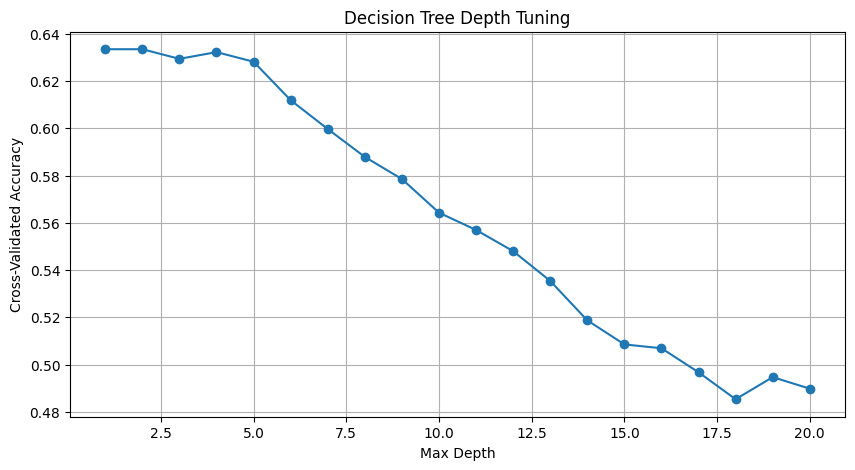

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(depths, cv_scores, marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Decision Tree Depth Tuning")
plt.grid(True)
plt.show()


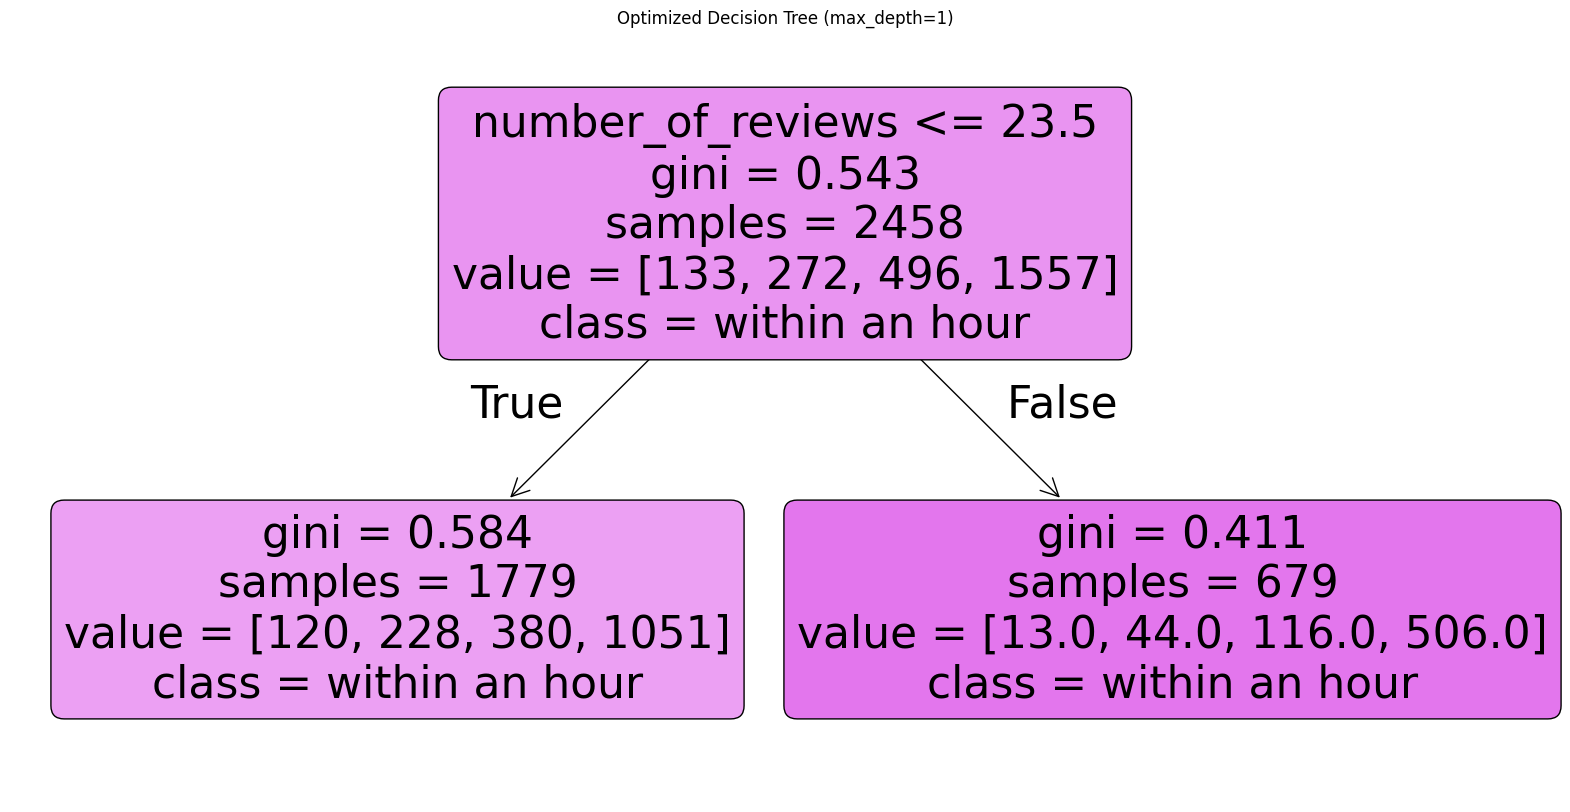

In [17]:
# Retrain final tree with best depth
best_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree.fit(X, y)

# Visualize
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=features, class_names=le.classes_, filled=True, rounded=True)
plt.title(f"Optimized Decision Tree (max_depth={best_depth})")
plt.show()


### Final Decision Tree Classification: Host Response Time

To predict the `host_response_time` variable, we explored several classification models and tuned decision tree depths to find the best fit. We initially trained a full-depth decision tree but noticed that deeper trees led to reduced cross-validated accuracy. By testing depths ranging from 1 to 20, we found that the optimal performance was achieved at a depth of 1. This surprisingly shallow tree still managed to yield meaningful insights with a cross-validated accuracy of around 63%.

The most important predictor in the final tree was the `number_of_reviews`. The model split the data at 23.5 reviews, indicating that listings with more than this number were far more likely to have hosts who respond "within an hour." This is intuitive—experienced or high-volume hosts are more responsive, likely due to familiarity with the platform or the use of automated tools. While the model isn't highly complex, it provides a simple and interpretable way to understand what influences fast host response times.


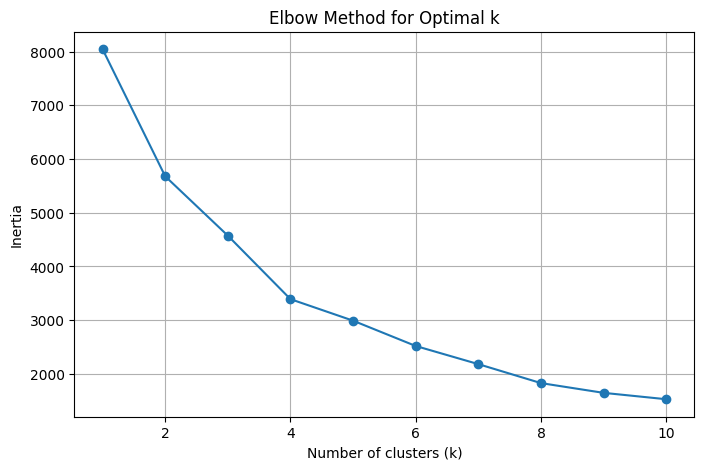

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select only numeric features for clustering
numeric_features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews', 'review_scores_rating']
X_cluster = df_clean[numeric_features].dropna()

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# KMeans Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


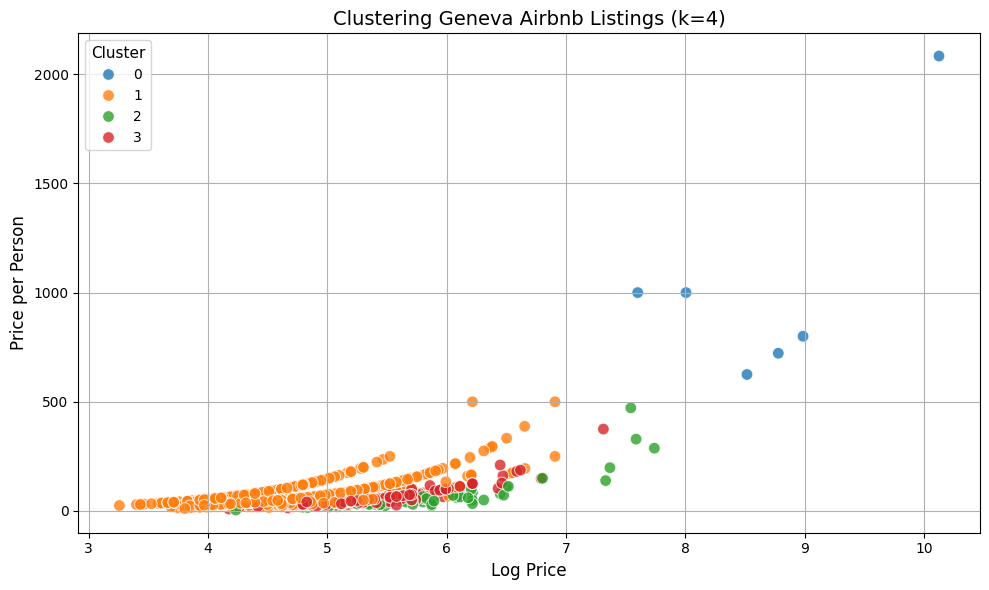

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
df_cluster = df_clean.copy()
df_cluster['price_per_person'] = df_cluster['price'] / (df_cluster['accommodates'].replace(0, np.nan))
df_cluster['bathrooms_per_bedroom'] = df_cluster['bathrooms'] / (df_cluster['bedrooms'].replace(0, np.nan))
df_cluster['review_density'] = df_cluster['number_of_reviews'] / (df_cluster['availability_365'].replace(0, np.nan))
df_cluster['log_price'] = np.log1p(df_cluster['price'])  # safer log transform

# Select and clean features
features = ['log_price', 'accommodates', 'bedrooms', 'bathrooms', 
            'price_per_person', 'bathrooms_per_bedroom', 'review_density']
df_cluster = df_cluster[features].dropna()

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# K-Means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Visualization
bright_palette = sns.color_palette("tab10")[:4]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cluster,
    x='log_price',
    y='price_per_person',
    hue='cluster',
    palette=bright_palette,
    alpha=0.8,
    s=70
)

plt.title("Clustering Geneva Airbnb Listings (k=4)", fontsize=14)
plt.xlabel("Log Price", fontsize=12)
plt.ylabel("Price per Person", fontsize=12)
plt.legend(title="Cluster", title_fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()